In [156]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Funciones generales

In [157]:
def escala_de_grises(path):
    """
    Convierte una imagen a escala de grises.

    Argumentos:
    --> path (str): Ruta al archivo de imagen.

    Returns:
    --> PIL.Image.Image: Imagen en escala de grises.
    """
    return Image.open(path).convert("L")

def conversion_float(img):
    """
    Convierte una imagen a un arreglo NumPy de tipo float normalizado entre 0 y 1

    Argumentos:
    --> img (PIL.Image.Image): Imagen a convertir.

    Returns:
    --> np.ndarray: Arreglo NumPy de la imagen normalizada.
    """
    return np.array(img, dtype = np.float32) / 255.0

def comparacion_imagenes(img1, img2, S):
    """
    Compara dos imágenes mostrando la original y la reconstruida.

    Argumentos:
    --> img1 (np.ndarray): Imagen original.
    --> img2 (np.ndarray): Imagen reconstruida.
    --> S (int): Porcentaje de compresión utilizado en la reconstrucción.
    
    """
    plt.figure(figsize = (15,15))
    
    #Imagen original
    plt.subplot(1,2,1)
    plt.title("Imagen original", color = "red")
    plt.imshow(img1, cmap = "grey")
    plt.axis("off")

    #Imagen reconstruida
    plt.subplot(1,2,2)
    plt.title(f"Imagen reconstruida: S = {S}%", color = "blue")
    plt.imshow(img2, cmap = "grey")
    plt.axis("off")

# Ejercicio 1: Correlación

#### (a) Grafico de dispersion para pixeles vecinos

In [158]:
#Funcion para formar bloques de pixeles vecinos
def formar_vector_X(img):
    """ 
    Forma un vector X donde cada fila contiene dos píxeles vecinos verticalmente de la imagen.

    Argumentos:
    --> img (np.ndarray): Imagen en escala de grises como un arreglo NumPy.

    Returns:
    --> np.vstack: Matriz donde cada fila contiene dos píxeles vecinos verticalmente.
    """
    X1 = []
    X2 = []
    
    #Iteracion por filas
    for i in range(len(img)): 
        #En caso que la fila sea un número par, se agregan los pixeles a X1
        if i % 2 == 0: 
            X1.extend(img[i]) 
        else:
            #Caso contrario, se agregan a X2
            X2.extend(img[i])
    
    return np.vstack([X1, X2]).T #de esta manera, los pixeles vecinos verticalmente quedan en la misma fila

def grafico_dispersion(X, img, title1, title2):
    """ 
    Genera un gráfico de dispersión de los píxeles vecinos de una imagen junto con la imagen en escala de grises.

    Argumentos:
    --> X (np.ndarray): Matriz donde cada fila contiene dos píxeles vecinos.
    --> img (np.ndarray): Imagen en escala de grises como un arreglo NumPy.
    --> title1 (str): Título para la imagen en escala de grises.
    --> title2 (str): Título para el gráfico de dispersión.
    """
    _, axes = plt.subplots(1, 2, figsize = (10, 5))

    # Imagen en grises
    axes[0].imshow(img, cmap = "gray")
    axes[0].set_title(f"{title1}")
    axes[0].axis("off")

    # Gráfico de dispersión
    axes[1].scatter(X.T[0], X.T[1], s= 1, alpha = 0.5, color = "darkblue")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")
    axes[1].set_title(f"{title2}")

    plt.tight_layout()
    plt.show()


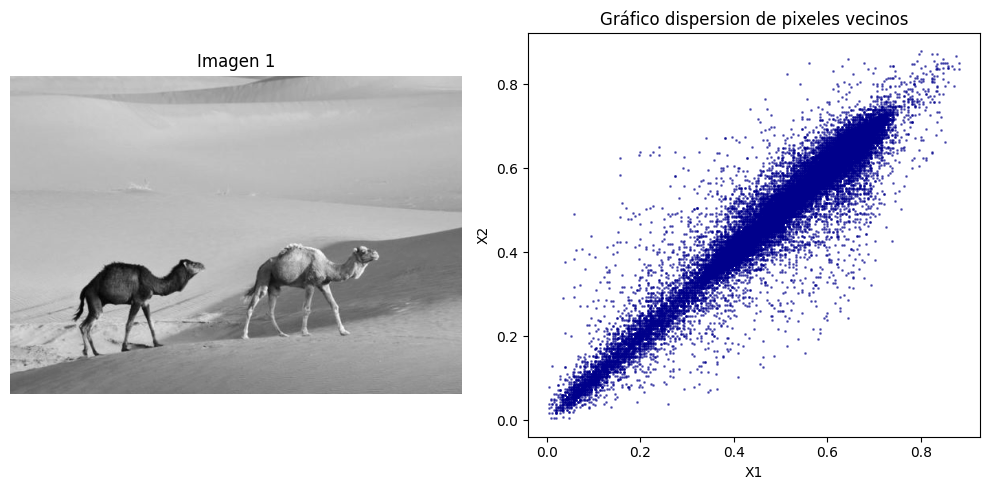

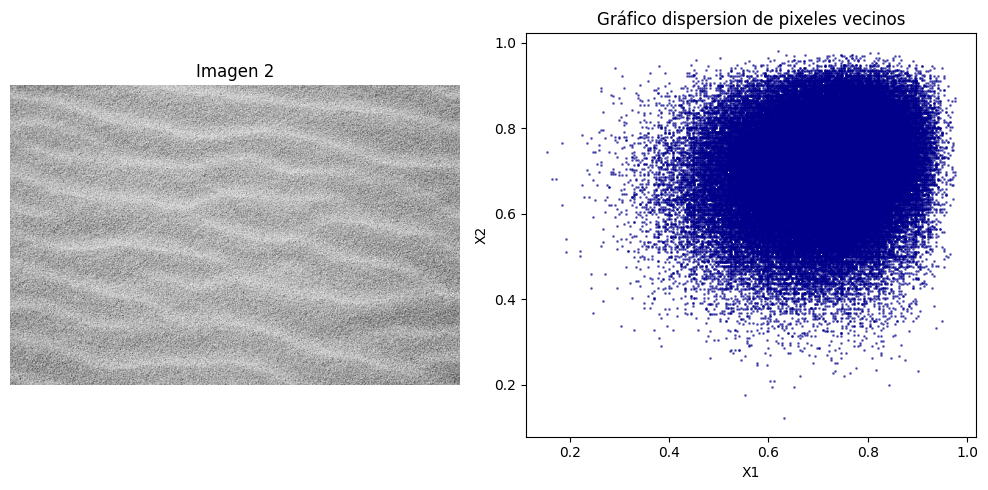

In [159]:
if __name__ == "__main__":
    #Cargar imagenes
    img1 = escala_de_grises("img_01.jpg")
    img2 = escala_de_grises("img_02.jpg")
    
    #Convertir a float
    img1_float = conversion_float(img1)
    img2_float = conversion_float(img2)

    #Grafico de dispersion para pixeles vecinos
    X1 = formar_vector_X(img1_float)
    X2 = formar_vector_X(img2_float)

    grafico_dispersion(X1, img1_float, "Imagen 1", "Gráfico dispersion de pixeles vecinos")
    grafico_dispersion(X2, img2_float, "Imagen 2", "Gráfico dispersion de pixeles vecinos")
    

#### (b) Estimación del coeficiente de correlación

In [160]:
def coef_correlacion(X):
    """
    Calcula el coeficiente de correlación entre dos variables representadas en las columnas de la matriz X.

    Argumentos: X (np.ndarray): Matriz donde cada fila contiene dos píxeles vecinos.

    Returns:
    --> float: Coeficiente de correlación entre las dos variables.
    """
    return np.corrcoef(X.T[0], X.T[1])[0,1]

In [161]:
if __name__ == "__main__":
    #Calculo del coeficiente de correlacion
    coef_correlacion_img1 = coef_correlacion(X1)
    coef_correlacion_img2 = coef_correlacion(X2)

    print(f"Coeficiente de correlación Imagen 1: {coef_correlacion_img1}")
    print(f"Coeficiente de correlación Imagen 2: {coef_correlacion_img2}")

#COMPLETAR CONCLUSION

Coeficiente de correlación Imagen 1: 0.9792211339601858
Coeficiente de correlación Imagen 2: 0.14585373552461373


##### Observamos que para la imagen uno, los pixeles vecinos estan altamente correlacionados, lo que significa que al conocer un pixel podemos deducir de el, el valor de su pixel vecino, por lo que hay redundancia. Se puede comprimir con  alta eficiencia y manteniendo la calidad

##### Por otro lado, para la segunda imagen, ocurre el caso contrario. Los pixeles están poco correlacionados, lo que signufica que son independientes, por lo que no se puede deducir el valor de un pixel basandose en su vecino. Esto implica el aumento de bits para comprimir la imagen....

#### (c) Desacoplamiento

In [162]:
def desacoplar(X):
    """
    Aplicacion de la transformacion Y = P^tX para desacoplar las variables de la matriz X.

    Argumentos:
    --> X (np.ndarray): Matriz donde cada fila contiene dos píxeles vecinos.

    Returns:
    --> Y (np.ndarray): Matriz transformada con variables desacopladas.
    --> P_ordenado (np.ndarray): Matriz de autovectores ordenados.
    --> Xc (np.ndarray): Matriz centrada (X - media).
    --> autovalores (np.ndarray): Autovalores ordenados de mayor a menor.
    --> mu_estimado (np.ndarray): Vector de medias de las columnas de X.
    """
    #Aplicación de la transformacion Y = P^t@X
    mu_estimado = np.mean(X, axis = 0) #calculo de la media
    Xc = X - mu_estimado #Vector centrado 

    #Cálculo de la covarianza entre pixeles vecinos
    Cx_estimado = np.cov(Xc, rowvar = False)

    #Descomposición espectral
    autovalores, P = np.linalg.eigh(Cx_estimado)
    
    index = np.argsort(autovalores)[::-1] #indices para ordenar autovalores de mayor a menor
    P_ordenado = P[:, index] #autovectores ordenados de mayor a menor segun autovalores
    autovalores = autovalores[index] #autovalores ordenados de mayor a menor

    #Transformacion lineal Y -> vector descorrelacionado
    Y = Xc @ P_ordenado
    
    return Y, P_ordenado, Xc, autovalores, mu_estimado

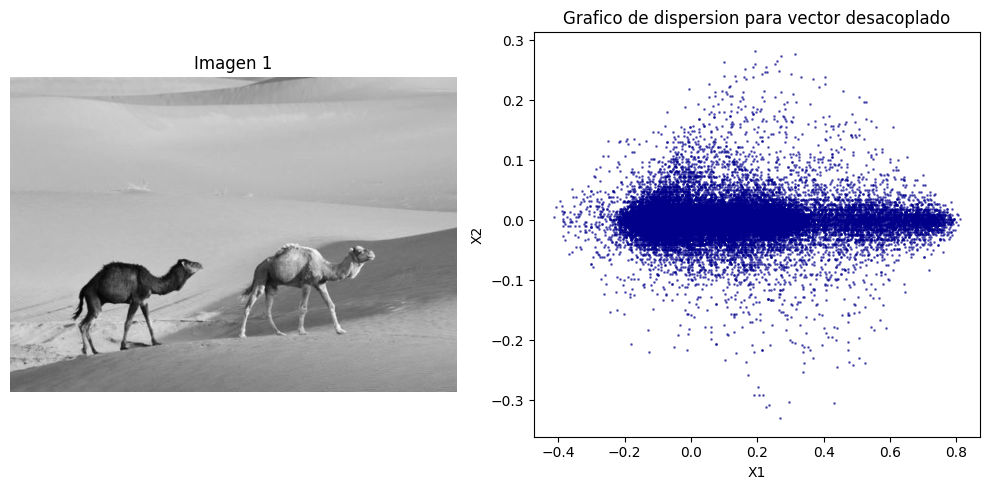

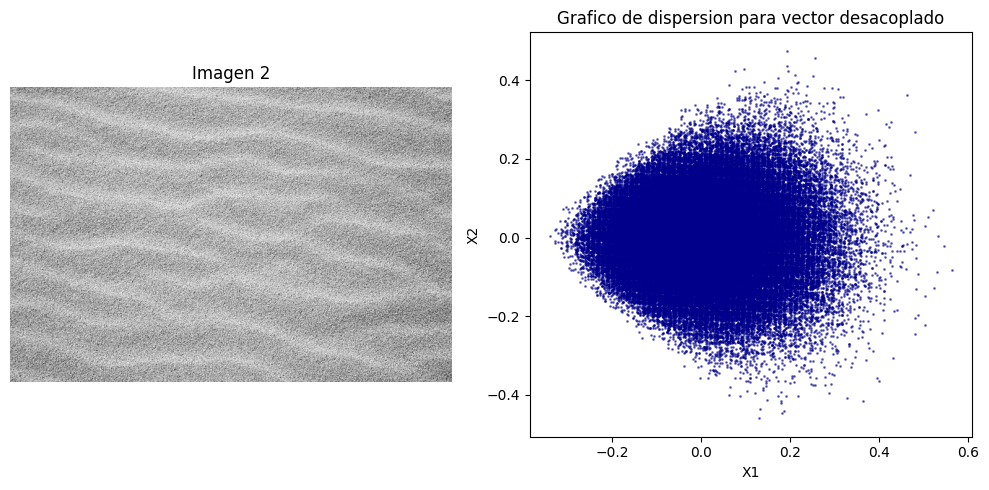

In [163]:
if __name__ == "__main__":
    #Imagen desacoplada
    Y1, _ , _, _, _ = desacoplar(X1)
    Y2, _, _, _ , _= desacoplar(X2)

    grafico_dispersion(Y1, img1_float, "Imagen 1", "Grafico de dispersion para vector desacoplado")
    grafico_dispersion(Y2, img2_float, "Imagen 2", "Grafico de dispersion para vector desacoplado")

##### Tras el proceso de descorrelación mediante PCA, en ambos casos, se logra el desacoplamiento de las variables, lo cual se evidencia en la ausencia de la nube inclinada. 
##### No obstante, se puede observar facilmente que, en la primera imagen, la varianza queda praticamente concentrada en la componente horizontal, lo que indica que originalmente existía una correlación más fuerte entre los píxeles vecinos. En la segunda fotografia, pese a que también predomina la componente horizontal, la dispersión es mayor en la dirección contraria al caso anterior, reflejando que la correlación inicial entre píxeles era menor.

# Ejercicio 2: Compresión

#### (a) Funcion de PCA

In [164]:
def pca_transform(X_bloques, k):
    """
    Aplicacion de PCA para reducir la dimensionalidad de la matriz de bloques de 64 x 1 a k dimensiones.

    Argumentos:
    --> X_bloques (np.ndarray): Matriz donde cada fila es un bloque de 64 píxeles.
    --> k (int): Número de dimensiones a las que se desea reducir.

    Returns:
    --> Yk (np.ndarray): Matriz proyectada a k dimensiones.
    --> Pk (np.ndarray): Matriz de proyección a k dimensiones.
    --> autovalores (np.ndarray): Autovalores ordenados de mayor a menor.
    --> mu_estimado (np.ndarray): Vector de medias de las columnas de X_bloques.
    """
    #Yk = Pk ^t @ Xc
    _, P_ordenado, Xc, autovalores, mu_estimado = desacoplar(X_bloques)
    
    Pk = P_ordenado[:, :k]  #matriz de proyección a k dimensiones
    
    Yk = Xc @ Pk #proyección a k dimensiones

    return Yk, Pk, autovalores, mu_estimado

#### (b) Aplicación de PCA

In [165]:
def bloques_8x8(img):
    """
    Forma bloques de 8x8 píxeles de una imagen y los convierte en vectores de 64x1, para luego apilarlos en una matriz.

    Argumentos:
    --> img (np.ndarray): Imagen en escala de grises como un arreglo NumPy.

    Returns:
    --> np.ndarray: Matriz donde cada columna es un bloque de 64 píxeles
    """
    #Recorte de la imagen a un multiplo de ocho
    filas_recortadas = img.shape[0] - (img.shape[0] % 8) #recorto a filas multiplo de ocho. El mod me da el sobrante.
    columnas_recortadas = img.shape[1] - (img.shape[1] % 8) #recorto a columnas multiplo de ocho
    img = img[:filas_recortadas, :columnas_recortadas]

    vectores_xi = []
    for i in range(0, img.shape[0], 8): #shape[0] = filas
        for j in range(0, img.shape[1], 8): #shape[1] = columnas
            bloque = img[i:i+8, j:j+8] #agarramos el bloque 8x8
            vectores_xi.append(bloque.flatten()) #convertimos el bloque en un vector de 64x1
    
    return np.vstack(vectores_xi).T

def k_valores(S, m):
    """ 
    Calcula el número de componentes principales k a retener para una compresión dada S%.

    Argumentos:
    --> S (float): Porcentaje de compresión deseado
    --> m (int): Cantidad de componentes totales

    Returns:
    --> k (int): Número de componentes principales a retener
    """
    k = int((1-(S/100))*m)
    
    return k


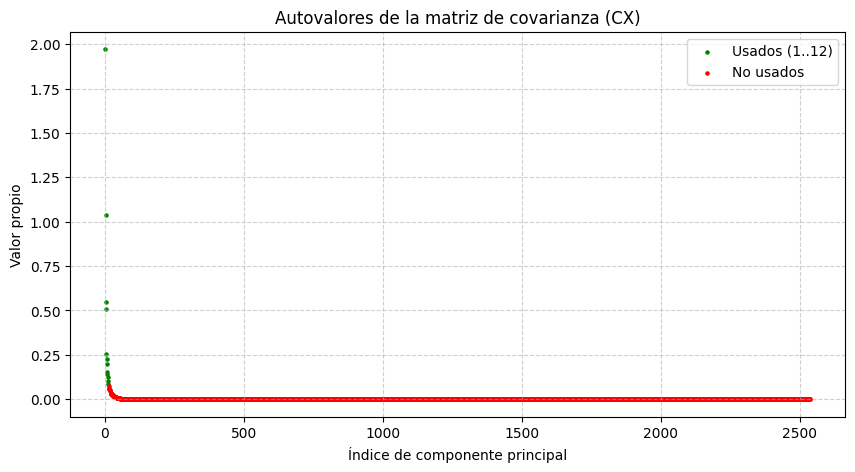

In [166]:
if __name__ == "__main__":
    #Cargar imagen
    img3 = escala_de_grises("img_03.jpg")
    #Convertir a float
    img3_float = conversion_float(img3)

    #Aplicacion de PCA
    k = k_valores(80, 64)
    bloques = bloques_8x8(img3_float)
    Yk, Pk, autovalores, mu_estimado = pca_transform(bloques, k)

    # Graficar autovalores
    plt.figure(figsize=(10,5))
    plt.scatter(range(1, k+1), autovalores[:k], color='green', s=5, label=f"Usados (1..{k})")
    plt.scatter(range(k+1, len(autovalores)+1), autovalores[k:], color='red', s=5, label="No usados")

    plt.xlabel("Índice de componente principal")
    plt.ylabel("Valor propio")
    plt.title("Autovalores de la matriz de covarianza (CX)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()


# Ejercicio 3: Descompresión

#### (a) Regeneracion

In [167]:
def descompresion(Yk, Pk, mu_x):
    """ 
    Aplicacion de la transformacion inversa X = P*Y + mu para reconstruir la matriz original a partir de la matriz proyectada Yk.

    Argumentos:
    --> Pk (np.ndarray): Matriz de proyección a k dimensiones.
    --> mu_x (np.ndarray): Vector de medias de las columnas de la matriz original X
    --> Yk (np.ndarray): Matriz proyectada a k dimensiones.

    Returns:
    --> np.ndarray: Matriz reconstruida aproximada de la original.
    """
    #Xk = Pk@Yk + mux
    return Yk @ Pk.T + mu_x

def reconstruccion(img, Yk, Pk, mu_x):

    """ 
    Reconstruye la imagen reemplazando cada bloque 8x8 por su versión reconstruida a partir de los componentes principales.

    Argumentos:
    --> img (np.ndarray): Imagen en escala de grises como un arreglo NumPy.
    --> Yk (np.ndarray): Matriz proyectada a k dimensiones.
    --> Pk (np.ndarray): Matriz de proyección a k dimensiones.
    --> mu_x (np.ndarray): Vector de medias de las columnas de la matriz original X

    Returns:
    --> np.ndarray: Imagen reconstruida.
    """
    
    X_reconstruido = descompresion(Yk, Pk, mu_x)

    filas = (img.shape[0] - (img.shape[0] % 8)) // 8
    columnas = (img.shape[1] - (img.shape[1] % 8))// 8
    
    #Creacion de una matriz de 0's = imagen en blanco 
    matriz_reconstruccion = np.zeros((filas * 8, columnas * 8), dtype=float)
    k = 0
    for i in range(filas):
        for j in range(columnas):
            bloque = X_reconstruido[:,k].reshape((8,8))
            matriz_reconstruccion[i*8: (i+1)*8, j*8: (j+1)*8] = bloque
            k += 1
    
    return imagen_reconstruida

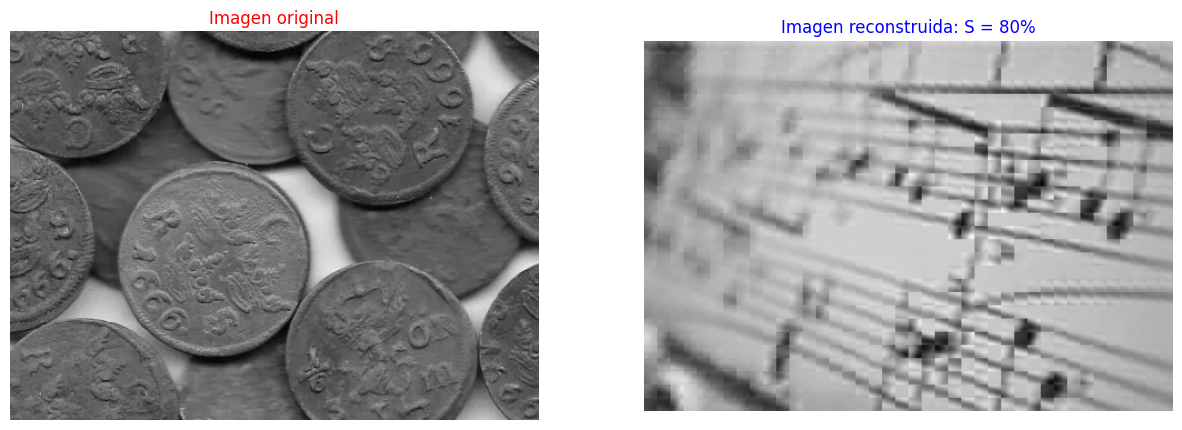

In [168]:
if __name__ == "__main__":
    imagen_reconstruida = reconstruccion(img3_float, Yk, Pk, mu_estimado)
    comparacion_imagenes(img3_float, imagen_reconstruida, 80)

# Ejercicio 4: Medidas de desempeño

#### (a) Cálculo del Medium Square Error (MSE)

In [169]:
def comprimir_imgen(img, S):
    """
    Comprime una imagen utilizando PCA y la reconstruye.

    Argumentos:
    --> img (np.ndarray): Imagen en escala de grises como un arreglo NumPy.
    --> S (float): Porcentaje de compresión deseado

    Returns:
    --> np.ndarray: Imagen reconstruida después de la compresión.
    """
    k = k_valores(S, 64)
    bloques = bloques_8x8(img)
    Yk, Pk, _, mu_estimado = pca_transform(bloques, k)

    imagen_reconstruida = reconstruccion(img, Yk, Pk, mu_estimado)

    return imagen_reconstruida

In [170]:

def calcular_MSE(img, S):
    """
    Calcula el Error Cuadrático Medio (MSE) entre la imagen original y la imagen reconstruida después de la compresión.

    Argumentos:
    --> img (np.ndarray): Imagen en escala de grises como un arreglo NumPy.
    --> S (float): Porcentaje de compresión deseado

    Returns:
    --> float: Valor del Error Cuadrático Medio (MSE).
    """
    imagen_reconstruida = comprimir_imgen(img, S)

    Nw = imagen_reconstruida.shape[0] #filas
    Nh = imagen_reconstruida.shape[1] #columnas

    MSE = 0

    #calculo el errror cuadratico medio
    for i in range(Nw):
        suma_parcial = 0
        for j in range(Nh):
            suma_parcial += (img[i][j] - imagen_reconstruida[i][j])**2
        
        MSE += suma_parcial / (Nh*Nw)

    return MSE

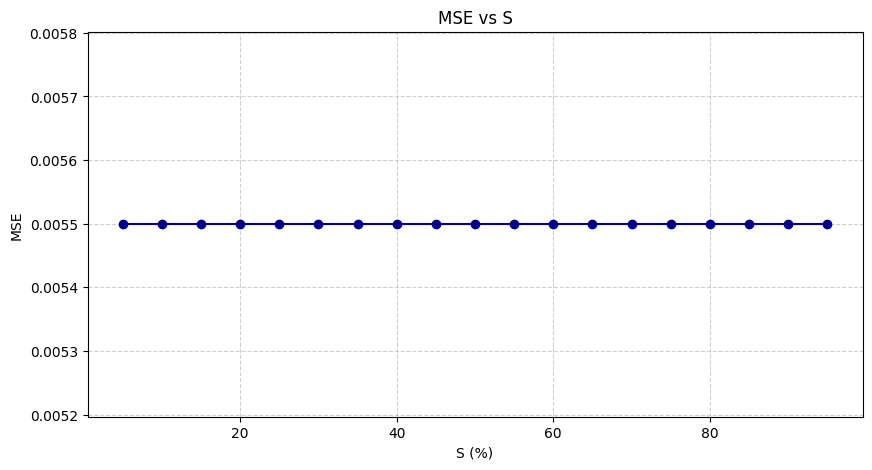

In [173]:
if __name__ == "__main__":
    #Cargar imagen
    img4 = escala_de_grises("img_04.jpg")
    #Convertir a float
    img4_float = conversion_float(img4)

    S_valores = [5*n for n in range(1, 20)]
    MSE_valores = [calcular_MSE(img4_float, s) for s in S_valores]

    #Grafico MSE vs S
    plt.figure(figsize=(10,5))
    plt.plot(S_valores, MSE_valores, marker='o', color='darkblue')
    plt.xlabel("S (%)")
    plt.ylabel("MSE")
    plt.title("MSE vs S")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

#### (b) Casos para S

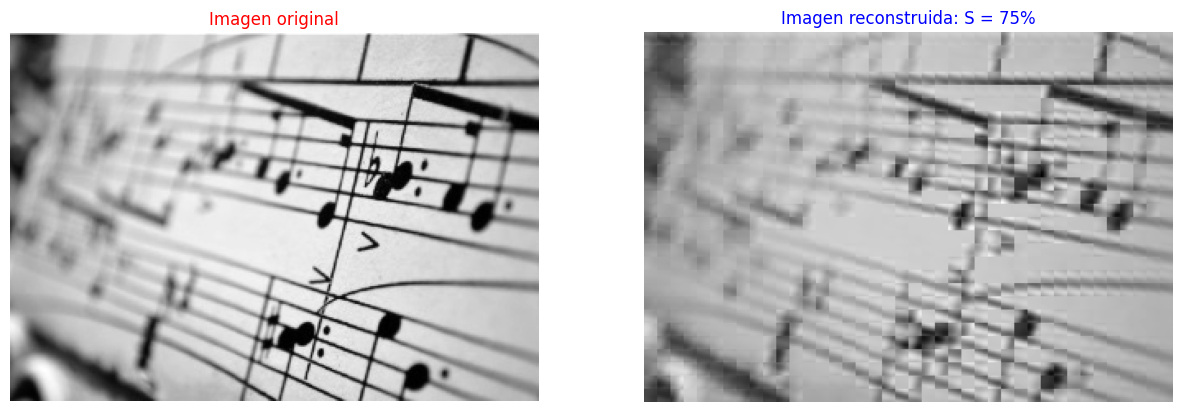

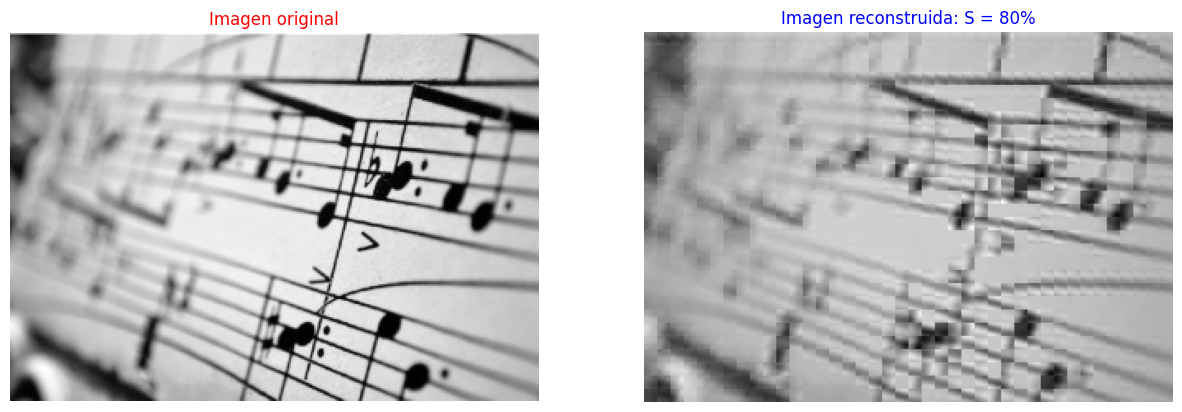

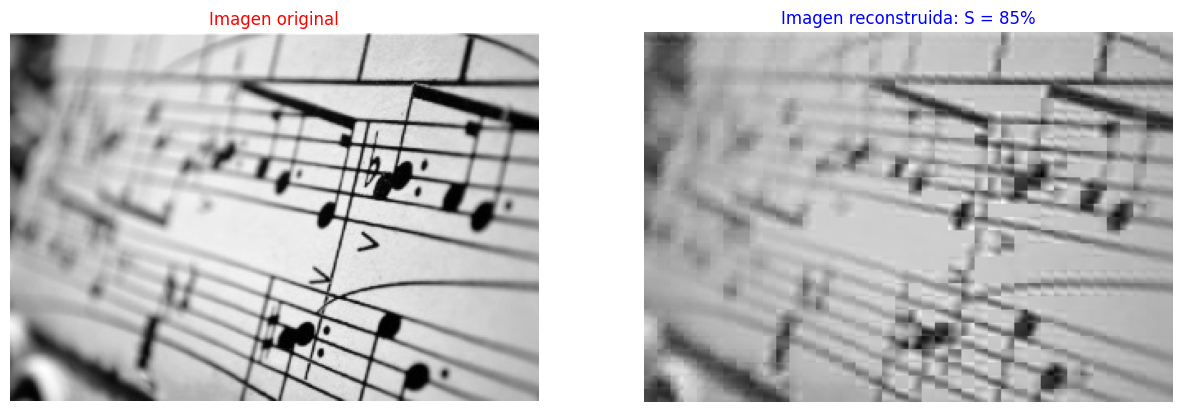

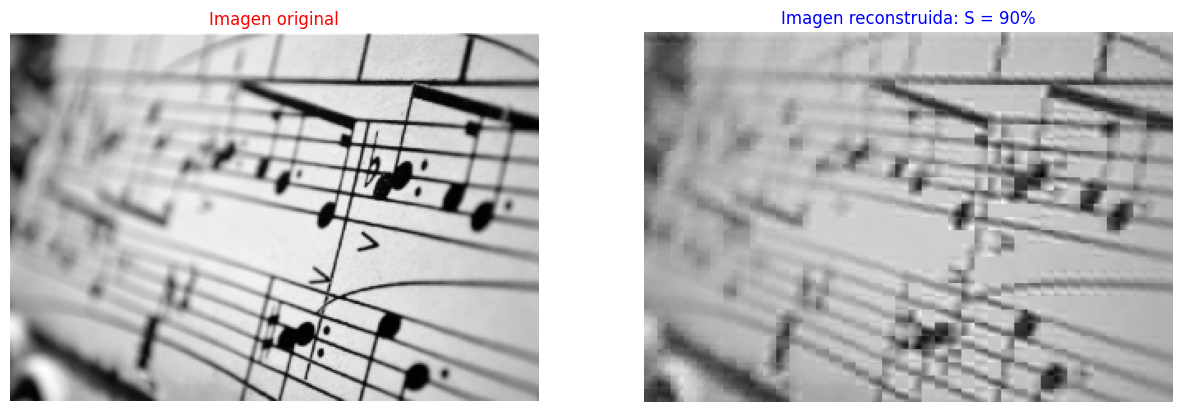

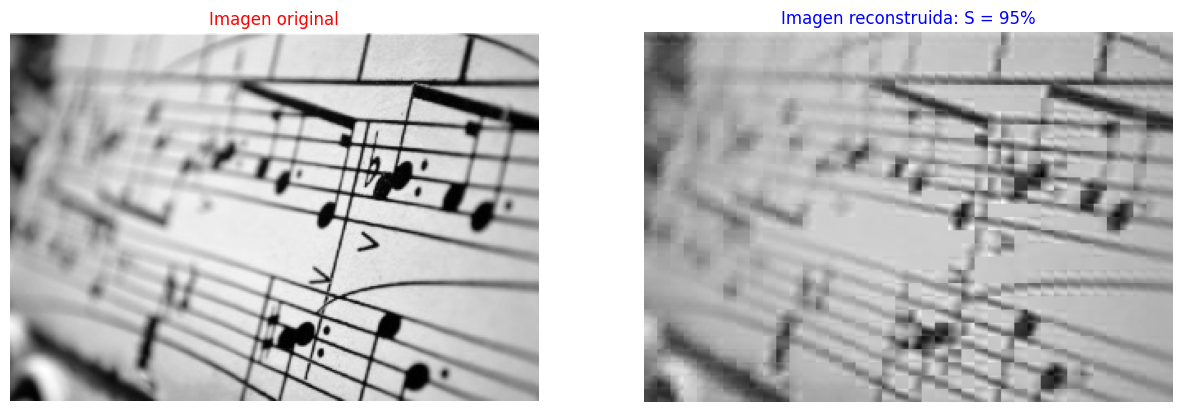

In [172]:
if __name__ == "__main__":
    img4 = escala_de_grises("img_04.jpg")
    #Convertir a float
    img4_float = conversion_float(img4)

    S = [75,80,85,90,95]
    for s in S:
        imagen_reconstruida = comprimir_imgen(img4_float, s)
        comparacion_imagenes(img4_float, imagen_reconstruida, s)
